# Assignment 2: Policy Gradient Methods


In [2]:
# Automatically reload changes to external code
%load_ext autoreload
%autoreload 2

In this assignment, you will implement the "vanilla" policy gradient method, i.e., a method that repeatedly computes estimates $\hat{g}$ of $\nabla_{\theta} E[\sum_t R_t]$ and takes gradient ascent steps $\theta \rightarrow \theta + \epsilon \hat{g}$.
To keep our code generic, so that we can write the same code to solve multiple MDPs with multiple policy parameterizations, we'll use classes for Policy and MDP. You can view the base classes in the file `rl.py`.

We will use a grid-world MDP called FrozenLake.
The following code constructs an instance of the MDP, and then prints its documentation.

In [3]:
from rl import rollout, Policy
from frozen_lake import FrozenLake
import numpy as np, numpy.random as nr

np.random.seed(1)

map4x4 = [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"]
mdp = FrozenLake(map4x4)

# FrozenLake is a MDP with finite state and action that involves navigating across a frozen lake.
# (It's conventionally called a "grid-world" MDP, as the state space involves points in a 2D grid)
# Let's look at the docstring for details
print FrozenLake.__doc__
print "-----------------"


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    
-----------------


Next, we will define a random policy and use it to perform a rollout. The rollout data will be used for gradient checking.

In [4]:
class RandomDiscreteActionChooser(Policy):
    def __init__(self, n_actions):
        self.n_actions = n_actions
    def step(self, observation):
        return {"action":np.array([nr.randint(0, self.n_actions)])}

policy = RandomDiscreteActionChooser(mdp.n_actions)
    
rdata = rollout(mdp, policy, 100)
print rdata

{'terminated': True, 'rewards': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'observations': array([0, 0, 0, 0, 1, 0, 0, 4]), 'actions': array([1, 0, 3, 3, 0, 0, 0, 1]), 'pdists': array([None, None, None, None, None, None, None, None], dtype=object)}


In [5]:
s_n = rdata['observations'] # Vector of states (same as observations since MDP is fully-observed)
a_n = rdata['actions'] # Vector of actions (each is an int in {0,1,2,3})
n = a_n.shape[0] # Length of trajectory
q_n = np.random.randn(n) # Returns (random for the sake of gradient checking)
f_sa = np.random.randn(mdp.n_states, mdp.n_actions) # Policy parameter vector. explained shortly.

Now, a little explanation about the preceding definitions.
First, we are using the convention that the letters after the underscore indicate what is indexing the array.
For example, `s_n` has a single subscript `n`, meaning that it is a 1D vector, and we will use `n` to index over timesteps.
`f_sa` is a matrix, whose first dimension `s` indexes over states, and whose second dimension `a` indexes over actions.
This convention helps us avoid errors where axes are mismatched.

The policy for our discrete MDP will be encoded by the matrix `f_sa`. The action probabilities are defined by exponentiating this matrix (elementwise) and then normalizing across the `a` dimension so the probabilities add up to 1. I.e., the matrix of probabilities is defined as follows

In [6]:
def softmax_prob(f_na):    
    """
    Exponentiate f_na and normalize rows to have sum 1
    so each row gives a probability distribution over discrete
    action set
    """
    prob_nk = np.exp(f_na - f_na.max(axis=1,keepdims=True))
    prob_nk /= prob_nk.sum(axis=1,keepdims=True)
    return prob_nk

### Problem 1: implement policy gradient computation

Next, you're going to implement a function for computing the policy gradient.
We will define a function called `softmax_policy_checkfunc` -- your function should compute the gradient of it.

In [7]:
def softmax_policy_checkfunc(f_sa, s_n, a_n, q_n):
    r"""
    An auxilliary function that's useful for checking the policy gradient
    The inputs are 
    s_n : states (vector of int)
    a_n : actions (vector of int)
    q_n : returns (vectof of float)

    This function returns

    \sum_n \log \pi(a_n | s_n) q_n

    whose gradient is the policy gradient estimator

    \sum_n \grad \log \pi(a_n | s_n) q_n

    """
    f_na = f_sa[s_n]
    p_na = softmax_prob(f_na)
    n = s_n.shape[0]
    return np.log(p_na[np.arange(n), a_n]).dot(q_n)/n

def softmax_policy_gradient(f_sa, s_n, a_n, adv_n):
    """
    Compute policy gradient of policy for discrete MDP, where probabilities
    are obtained by exponentiating f_sa and normalizing
    """
    # YOUR CODE HERE >>>>>>
    # <<<<<<<< 
    softmax = softmax_prob(f_sa)
    grad = np.zeros(f_sa.shape)
    n = len(s_n)
    for i in range(n):
        s, a_i = s_n[i], a_n[i]
        p = softmax[s, a_i]
        for a in range(grad.shape[1]):
            # derivative of softmax
            # implicit division by p because we're taking gradient of log of probability
            if a == a_i:
                update = (1 - p)
            else:
                update = - softmax[s, a]
            grad[s, a] += update * adv_n[i]
    return grad / n



We'll verify your function by checking the gradient numerically. You'll need the `numdifftools` module, which computes highly-precise numerical gradient estimates. (To install this module, open up a shell and run `pip install numdifftools`)

In [8]:
import numdifftools as ndt

stepdir = np.random.randn(*f_sa.shape)
auxfunc = lambda x: softmax_policy_checkfunc(f_sa+stepdir*x, s_n, a_n, q_n)

numgrad = ndt.Derivative(auxfunc)(0)
g = softmax_policy_gradient(f_sa, s_n, a_n, q_n)
anagrad = (stepdir*g).sum()

assert abs(numgrad - anagrad) < 1e-10

Now you have a function that computes the policy gradient. Now you're ready to write a function that uses it to optimize the policy.
First we'll define a Policy class that'll be used by your policy gradient optimization algorithm.

In [9]:
from hw_utils import Message, discount, fmt_row
from rl import rollout, pathlength
import numpy as np
from collections import defaultdict
from categorical import cat_sample, cat_entropy, cat_kl
import matplotlib.pyplot as plt

class FrozenLakeTabularPolicy(Policy):
    def __init__(self, n_states):
        self.n_states = n_states
        self.n_actions = n_actions = 4        
        self.f_sa = np.zeros((n_states, n_actions))

    def step(self, s_n):
        f_na = self.f_sa[s_n]
        prob_nk = softmax_prob(f_na)
        acts_n = cat_sample(prob_nk)
        return {"action":acts_n,
                "pdist" : f_na}
    
    
    def compute_pdists(self, s_n):
        return self.f_sa[s_n]

    def compute_entropy(self, f_na):
        prob_nk = softmax_prob(f_na)
        return cat_entropy(prob_nk)

    def compute_kl(self, f0_na, f1_na):
        p0_na = softmax_prob(f0_na)
        p1_na = softmax_prob(f1_na)
        return cat_kl(p0_na, p1_na)

### Problem 2: Implement policy gradient optimization algorithm

Complete the function below, to obtain an algorithm that optimizes the policy by computing policy gradient estimates.
Output of a successful implementation is shown below this cell. Your result doesn't need to be exactly the same numerically, but the performance should be on far.

In [77]:
def policy_gradient_optimize(mdp, policy,
        gamma,
        max_pathlength,
        timesteps_per_batch,
        n_iter,
        stepsize):
    stat2timeseries = defaultdict(list)
    widths = (17,10,10,10,10)
    print fmt_row(widths, ["EpRewMean","EpLenMean","Perplexity","KLOldNew"])
    for i in xrange(n_iter):
        total_ts = 0
        paths = [] 
        while True:
            path = rollout(mdp, policy, max_pathlength)                
            paths.append(path)
            total_ts += pathlength(path)
            if total_ts > timesteps_per_batch: 
                break

        # get observations:
        obs_no = np.concatenate([path["observations"] for path in paths])

        # Your code should compute the policy gradient and update the policy parameters
        # you'll need to compute the discounted returns, compute the policy gradient, and update the parameters
        # YOUR CODE HERE >>>>>>
        update = None
        for path in paths:
            returns = path['rewards']
            discounted_returns = np.zeros(len(returns) + 1)
            for i in reversed(range(len(returns))):
                discounted_returns[i] = returns[i] + gamma * discounted_returns[i+1]
            grad = softmax_policy_gradient(policy.f_sa, path['observations'], path['actions'], discounted_returns)
            if update is None:
                update = grad
            else:
                update += grad
        policy.f_sa = policy.f_sa + stepsize * update / len(paths)
        # <<<<<<<< 

        pdists = np.concatenate([path["pdists"] for path in paths])
        kl = policy.compute_kl(pdists, policy.compute_pdists(obs_no)).mean()
        perplexity = np.exp(policy.compute_entropy(pdists).mean())

        stats = {  "EpRewMean" : np.mean([path["rewards"].sum() for path in paths]),
                   "EpRewSEM" : np.std([path["rewards"].sum() for path in paths])/np.sqrt(len(paths)),
                   "EpLenMean" : np.mean([pathlength(path) for path in paths]),
                   "Perplexity" : perplexity,
                   "KLOldNew" : kl }
        print fmt_row(widths, ['%.3f+-%.3f'%(stats["EpRewMean"], stats['EpRewSEM']), stats['EpLenMean'], stats['Perplexity'], stats['KLOldNew']])
        
        
        for (name,val) in stats.items():
            stat2timeseries[name].append(val)
    return stat2timeseries
            
policy = FrozenLakeTabularPolicy(mdp.n_states)

np.random.seed(0)            
stat2ts = policy_gradient_optimize(mdp, policy,
                gamma=.98,
                max_pathlength=100,
                timesteps_per_batch=2000,
                n_iter=100,
                stepsize=100)

        EpRewMean |  EpLenMean | Perplexity |   KLOldNew
     0.017+-0.008 |    8.39749 |          4 | 0.000966469
     0.028+-0.010 |       8.02 |     3.9959 | 0.00260742
     0.019+-0.008 |    7.44238 |    3.98988 | 0.000257249
     0.020+-0.009 |    8.16735 |     3.9893 | 0.000638965
     0.021+-0.009 |    8.33884 |    3.99059 | 0.000709634
     0.021+-0.009 |     8.2428 |    3.98577 | 0.000900842
     0.028+-0.011 |    8.11741 |    3.97634 | 0.000740827
     0.020+-0.009 |          8 |    3.97374 | 0.000453128
     0.014+-0.007 |    6.95848 |    3.97407 | 0.000358569
     0.023+-0.009 |    7.79767 |    3.96551 | 0.00115601
     0.019+-0.009 |    7.72973 |    3.94779 | 0.000270134
     0.022+-0.009 |     7.4461 |     3.9467 | 0.00107828
     0.008+-0.005 |    7.77692 |    3.93302 | 0.000214503
     0.039+-0.012 |    7.89764 |    3.93374 | 0.00167379
     0.020+-0.009 |    7.86275 |    3.92928 | 0.000262816
     0.008+-0.006 |    7.98016 |    3.92525 | 0.000109266
     0.000+-0.000 |

In [78]:
# Output of successful implementation for problem 2...

#      0.232+-0.042 |    20.2525 |     1.7738 | 0.00553472
#      0.180+-0.041 |    22.5281 |    1.64021 | 0.000818475
#      0.286+-0.046 |    20.4592 |    1.65031 | 0.00210285
#      0.310+-0.050 |    23.1379 |    1.58822 | 0.000949984
#      0.229+-0.043 |    21.1667 |    1.51748 | 0.00126626
#      0.333+-0.053 |    25.7821 |    1.45515 | 0.00517389
#      0.279+-0.054 |    29.7794 |    1.45849 | 0.00126206
#      0.279+-0.054 |    29.8382 |    1.39328 | 0.000978533
#      0.405+-0.057 |     27.473 |    1.36296 | 0.00081737
#      0.395+-0.056 |    26.5921 |    1.33036 | 0.000578766
#      0.439+-0.061 |    30.9394 |    1.29982 | 0.000903682
#      0.403+-0.062 |    32.6935 |    1.28342 |  0.0003479
#      0.461+-0.057 |    26.3421 |    1.30297 | 0.000425174
#      0.368+-0.058 |    30.6912 |    1.27384 | 0.000224248
#      0.545+-0.061 |    30.5758 |     1.2691 | 0.00110955
#      0.508+-0.062 |    31.2308 |    1.26778 | 0.000117507
#      0.391+-0.061 |    31.5156 |      1.242 | 0.000249331
#      0.365+-0.061 |    31.9048 |     1.2347 | 0.000131674
#      0.492+-0.064 |    32.8852 |    1.25998 | 0.000360727
#      0.394+-0.058 |    28.4648 |    1.21109 | 0.000364956
#      0.419+-0.063 |    32.4032 |    1.22287 | 0.000336991
#      0.582+-0.067 |    37.6909 |    1.21275 | 0.00017788
#      0.485+-0.062 |    30.4545 |    1.24474 | 0.000368472
#      0.509+-0.067 |    36.4909 |    1.19584 | 0.000191174
#      0.576+-0.064 |    33.9831 |     1.1816 | 8.99578e-05
#      0.690+-0.061 |    35.1379 |    1.17238 | 0.000160158
#      0.627+-0.063 |    34.1356 |    1.16137 | 8.35832e-05
#      0.500+-0.071 |      40.34 |    1.16211 | 9.52723e-05
#      0.464+-0.067 |    36.8036 |    1.17209 | 8.54947e-05
#      0.509+-0.066 |    35.6491 |    1.16041 | 7.82523e-05
#      0.632+-0.064 |    35.1579 |    1.15874 | 7.54936e-05
#      0.582+-0.067 |    36.5273 |    1.15924 | 8.17684e-05
#      0.630+-0.066 |    37.3704 |     1.1467 | 0.000170618
#      0.583+-0.064 |    33.5167 |    1.15033 | 4.80961e-05
#      0.662+-0.057 |    30.6324 |    1.13978 | 7.26294e-05
#      0.618+-0.066 |    36.8545 |    1.13128 | 3.96185e-05
#      0.529+-0.070 |    39.8431 |     1.1494 | 9.74017e-05
#      0.589+-0.066 |    36.4107 |    1.13971 | 0.000125295
#      0.644+-0.062 |    34.1695 |    1.12859 | 4.46991e-05
#      0.625+-0.065 |    36.6071 |    1.11733 | 3.96966e-05
#      0.526+-0.066 |    36.1053 |    1.13024 | 7.80788e-05
#      0.667+-0.061 |    33.8667 |    1.10236 | 0.000207277
#      0.617+-0.063 |      33.85 |    1.10662 | 6.32027e-05
#      0.529+-0.070 |    39.8627 |    1.11525 | 2.46512e-05
#      0.577+-0.069 |    38.7885 |    1.11533 | 1.71757e-05
#      0.656+-0.061 |     34.082 |    1.14483 | 0.000279053
#      0.709+-0.061 |    37.0182 |     1.1183 | 5.70132e-05
#      0.589+-0.066 |    36.0536 |    1.13235 | 3.61136e-05
#      0.714+-0.060 |    36.3929 |    1.12589 | 7.89316e-05
#      0.617+-0.063 |    33.6333 |    1.11578 | 0.000110617
#      0.661+-0.062 |    34.9661 |    1.11546 | 0.000102611
#      0.661+-0.062 |    34.1864 |    1.12734 | 0.000132361
#      0.660+-0.069 |    42.7872 |    1.10657 | 0.000389893
#      0.732+-0.059 |    35.8036 |    1.12287 | 0.000284315
#      0.569+-0.065 |    34.9483 |    1.11962 | 0.000197253

# Several plots can be generated from the results:

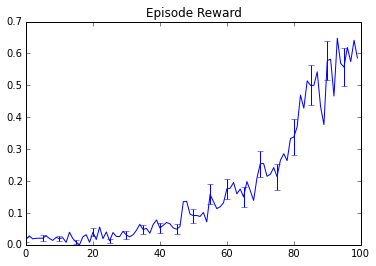

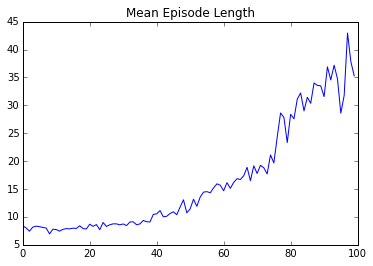

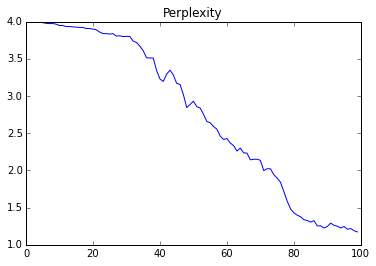

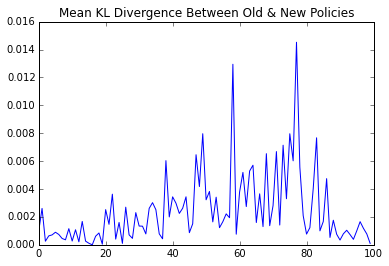

In [79]:
%matplotlib inline
plt.figure()
plt.title("Episode Reward")
EpRewMean = np.array(stat2ts["EpRewMean"])
EpRewStd = np.array(stat2ts["EpRewSEM"])
plt.errorbar(np.arange(len(EpRewMean)), EpRewMean, yerr=EpRewStd, errorevery=5, linewidth=1)
plt.figure()
plt.title("Mean Episode Length")
plt.plot(stat2ts["EpLenMean"])
plt.figure()
plt.title("Perplexity")
plt.plot(stat2ts["Perplexity"])
plt.figure()
plt.title("Mean KL Divergence Between Old & New Policies")
plt.plot(stat2ts["KLOldNew"]);

Note that the perplexity goes down to 1, corresponding to a deterministic policy.

Let's "plot" the learned policy:

In [80]:
from rl import animate_rollout
animate_rollout(mdp,policy,delay=.001,horizon=100)

action:  None
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  UP
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  UP
SFFF
FHFH
FFFH
HFFG
action:  DOWN
SFFF
FHFH
FFFH
HFFG
action:  UP
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  UP
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  LEFT
SFFF
FHFH
FFFH
HFFG
action:  UP
SFFF
FHFH
FFFH
HFFG
action:  DOWN
SFFF
FHFH
FFFH
HFFG
action:  RIGHT
SFFF
FHFH
FFFH
HFFG
terminated after 24 timesteps


### Problem 3: Implement some enhancement or variation on policy gradient optimization algorithm

Some possibilities:
- add a state-dependent baseline function
- use RMSProp, momentum gradient descent, or ADAM as the underlying stochastic optimization algorithm instead of SGD
- implement some variant of the natural gradient algorithm or trust region policy optimization
- something else that you invented

Run your algorithm on the mdp above (with a 4x4 grid), and also run it on the following 8x8 grid.
Plot the learning curve you obtain. You will probably have to tune stepsize, and it might help to adjust the discount factor gamma.

    map8x8 = [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]


In [71]:
def policy_gradient_optimize_enhanced(mdp, policy,
        gamma,
        max_pathlength,
        timesteps_per_batch,
        n_iter,
        stepsize,
        decay_iter,
        rms_decay):
    stat2timeseries = defaultdict(list)
    widths = (17,10,10,10,10)
    print fmt_row(widths, ["EpRewMean","EpLenMean","Perplexity","KLOldNew"])
    
    grad_dim = policy.f_sa.shape
    meansquare = np.ones(grad_dim)
    for i in xrange(n_iter):
        total_ts = 0
        paths = [] 
        while True:
            path = rollout(mdp, policy, max_pathlength)                
            paths.append(path)
            total_ts += pathlength(path)
            if total_ts > timesteps_per_batch: 
                break

        # get observations:
        obs_no = np.concatenate([path["observations"] for path in paths])

        update = np.zeros(policy.f_sa.shape)
        for path in paths:
            returns = path['rewards']
            obs = path['observations']
            discounted_returns = np.zeros(len(returns) + 1)
            for i in reversed(range(len(returns))):
                discounted_returns[i] = returns[i] + gamma * discounted_returns[i+1]
            update += softmax_policy_gradient(policy.f_sa, obs, path['actions'], discounted_returns)
        gradient = -update / len(paths)
        
        # added: RMSProp (based on http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
        meansquare = (1 - rms_decay) * meansquare + rms_decay * (gradient ** 2)
        if i == 100:
            stepsize /= 10
        policy.f_sa = policy.f_sa - (stepsize / (i + 1)) * (gradient / (meansquare ** 0.5 + 1e-06))

        pdists = np.concatenate([path["pdists"] for path in paths])
        kl = policy.compute_kl(pdists, policy.compute_pdists(obs_no)).mean()
        perplexity = np.exp(policy.compute_entropy(pdists).mean())

        stats = {  "EpRewMean" : np.mean([path["rewards"].sum() for path in paths]),
                   "EpRewSEM" : np.std([path["rewards"].sum() for path in paths])/np.sqrt(len(paths)),
                   "EpLenMean" : np.mean([pathlength(path) for path in paths]),
                   "Perplexity" : perplexity,
                   "KLOldNew" : kl }
        print fmt_row(widths, ['%.3f+-%.3f'%(stats["EpRewMean"], stats['EpRewSEM']), stats['EpLenMean'], stats['Perplexity'], stats['KLOldNew']])
        
        
        for (name,val) in stats.items():
            stat2timeseries[name].append(val)
    return stat2timeseries

In [48]:
np.random.seed(0)
mdp4x4 = FrozenLake(map4x4)
policy4x4 = FrozenLakeTabularPolicy(mdp4x4.n_states)
stat2ts4x4 = policy_gradient_optimize_enhanced(mdp4x4, policy4x4,
                gamma=.98,
                max_pathlength=200,
                timesteps_per_batch=2000,
                n_iter=100,
                stepsize=10,
                rms_decay=0.1)

        EpRewMean |  EpLenMean | Perplexity |   KLOldNew
     0.017+-0.008 |    8.39749 |          4 | 0.00107478
     0.028+-0.010 |     7.9249 |    3.99541 | 0.00316754
     0.019+-0.008 |    7.52632 |    3.98803 | 0.000362628
     0.020+-0.009 |    8.06855 |    3.98715 | 0.000979693
     0.016+-0.008 |    8.23673 |    3.98867 | 0.00107682
     0.020+-0.009 |    8.20902 |    3.98286 | 0.00182033
     0.034+-0.011 |    7.68199 |    3.96761 | 0.00160917
     0.020+-0.009 |    8.22951 |    3.96283 | 0.00203084
     0.033+-0.011 |    7.30545 |    3.95074 | 0.00268324
     0.039+-0.012 |    7.80545 |     3.9207 | 0.00682424
     0.034+-0.011 |    7.50562 |    3.82514 | 0.00564274
     0.031+-0.011 |    7.77132 |    3.74399 | 0.00370049
     0.024+-0.010 |       8.06 |    3.63377 | 0.00142534
     0.015+-0.008 |    7.59091 |    3.60254 | 0.00248836
     0.029+-0.010 |    7.30657 |    3.60631 | 0.00765981
     0.019+-0.008 |    7.45926 |    3.72614 | 0.00467187
     0.023+-0.009 |    7.6781

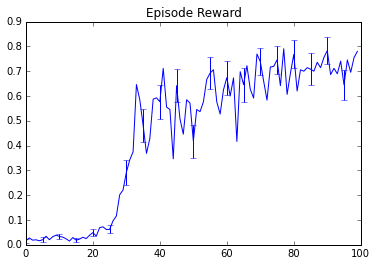

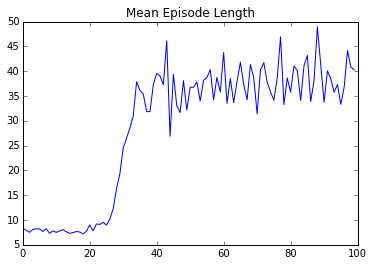

In [49]:
%matplotlib inline
plt.figure()
plt.title("Episode Reward")
EpRewMean = np.array(stat2ts4x4["EpRewMean"])
EpRewStd = np.array(stat2ts4x4["EpRewSEM"])
plt.errorbar(np.arange(len(EpRewMean)), EpRewMean, yerr=EpRewStd, errorevery=5, linewidth=1)
plt.figure()
plt.title("Mean Episode Length")
plt.plot(stat2ts4x4["EpLenMean"])

In [ ]:
np.random.seed(0)
map8x8 = [
    "SFFFFFFF",
    "FFFFFFFF",
    "FFFHFFFF",
    "FFFFFHFF",
    "FFFHFFFF",
    "FHHFFFHF",
    "FHFFHFHF",
    "FFFHFFFG"
]
mdp8x8 = FrozenLake(map8x8)
policy8x8 = FrozenLakeTabularPolicy(mdp8x8.n_states)
stat2ts8x8 = policy_gradient_optimize_enhanced(mdp8x8, policy8x8,
                gamma=.99,
                max_pathlength=400,
                timesteps_per_batch=10000,
                n_iter=400,
                stepsize=300,
                rms_decay=0.1)

In [ ]:
plt.figure()
plt.title("Episode Reward")
EpRewMean = np.array(stat2ts8x8["EpRewMean"])
EpRewStd = np.array(stat2ts8x8["EpRewSEM"])
plt.errorbar(np.arange(len(EpRewMean)), EpRewMean, yerr=EpRewStd, errorevery=5, linewidth=1)
plt.figure()
plt.title("Mean Episode Length")
plt.plot(stat2ts8x8["EpLenMean"])

### Problem 4: Experiment with Atari domain

For this problem, you will experiment with the Atari domain. You will learn a policy to play Atari using the RAM state of the Atari emulator as input. It's significantly easier and faster to train that using images; however, it's still a highly non-trivial problem. In the instructors' experience, methods that work well on RAM also work well on images.

First, build the required libraries by navigating into the code directory and running

    ./setup_ale.sh

You have two choices
1. Use the instructor's implementation of *Proximal Policy Optimization* (A variant of [Trust Region Policy Optimization](http://arxiv.org/abs/1502.05477) which is simpler because it solves an unconstrained optimization problem). The code is provided in `ppo.py`. It requires [CGT](http://rll.berkeley.edu/cgt). Implement some variation on this algorithm. Some possibilities:
   - Use a neural network value function instead of a linear value function
   - Adjust the KL divergence penalty coefficient in an adaptive way so that the KL divergence is roughly fixed across iterations.
   - Use SGD instead of LBFGS on each batch
   - Use a different kind of discounting scheme, e.g. hyperbolic discounts
   - Vary the neural network architecture of the policy
   - Something else that you invented
2. Implement a policy gradient method yourself, and run that. For example, you could use the policy gradient method you implemented in problems 1-3. In my experience, "vanilla" policy gradient methods don't work very well on this problem in a reasonable amount of time, but you may be able to get it working with some tinkering.

Note: it's quite helpful to plot what the current policy is doing, as a diagnostic. To do this, you can use the `animate_rollout` function in `rl.py`.
Also, it's helpful to run simulations in parallel, because simulation is usually the bottleneck on these problems with relatively low-dimensional inputs. See `ppo.py` for an example of how to do this with the multiprocessing module.

<div class="alert alert-warning">
**Final Deliverable**: implement a policy gradient algorithm for Atari, following guidelines of (1) and (2) above, and perform a comparison of at least two different experimental conditions. E.g. [reference implementation, your variant], or [your idea 1, your idea 2, your idea 3]. Plot learning curves (i.e. the mean episode reward) for all experimental conditions.

You may want to write the code outside of this notebook (if so, please include it in a zip file with your submission), but please put the plots **here**.
</div>



In [ ]:
import h5py
# reference implemnetation
print('Reference:')
stats_file = h5py.File('output/reference_stats.h5')
ts = stats_file['diagnostics']
plt.figure()
plt.title("Episode Reward")
EpRewMean = np.array(ts["EpRewMean"])
EpRewStd = np.array(ts["EpRewSEM"])
plt.errorbar(np.arange(len(EpRewMean)), EpRewMean, yerr=EpRewStd, errorevery=5, linewidth=1)
plt.figure()
plt.title("Mean Episode Length")
plt.plot(ts["EpLenMean"])


# using SGD instead of lbfgs:


### Problem 5: Experiment with MuJoCo / Locomotion

For this problem, you will experiment with the MuJoCo domain, and learn a controller that enables a simulated robot character to hop.

First, build the required libraries by navigating into the code directory and running

    ./setup_mujoco.py
    
Again, you have the choice of modifying the instructor's implementation or using your own implementation.
Follow the exact same instructions as in Problem 4 and plot learning curves showing the performance of your implementation.